## Housing prices prediction with gradient boosting

Hello everyone! In this notebook, I'm gonna use gradient boosting model to predict housing prices using CatBoost library. Let's start!

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error as mae
import eli5
from eli5.sklearn import PermutationImportance

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from catboost import CatBoostRegressor

### Loading data

In [2]:
train_data = pd.read_csv('../input/home-data-for-ml-course/train.csv', index_col='Id')
test_data = pd.read_csv('../input/home-data-for-ml-course/test.csv', index_col='Id')

### Function for scoring data

To know how changes in data will influence the result, I'll create this custom function. It uses X and y as input, then uses cross-validation on linear, random forest, and gradient boosting models and return result.

**Note:** improving the score of this function doesn't directly mean improving the score of the final result.

In [3]:
def score_data(X, y, random_state=42):
    l_model = LinearRegression()
    rf_model = RandomForestRegressor(random_state=random_state)
    gb_model = GradientBoostingRegressor(random_state=random_state)
    
    l_score = -1 * cross_val_score(l_model, X, y, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1).mean()
    rf_score = -1 * cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1).mean()
    gb_score = -1 * cross_val_score(gb_model, X, y, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1).mean()
    
    print(f'Data score:\nLinear regression: {l_score}\nRandom forest: {rf_score}\nGradient boosting: {gb_score}')

### Pipeline

To start, let's make a pipeline. It will use only numeric data without null values.

In [4]:
pipeline_X = train_data.copy().select_dtypes(exclude='O').dropna()
pipeline_y = pipeline_X.pop('SalePrice')

In [5]:
pipeline_y.isnull()

Id
1       False
2       False
3       False
4       False
5       False
        ...  
1456    False
1457    False
1458    False
1459    False
1460    False
Name: SalePrice, Length: 1121, dtype: bool

Now, use the function for scoring data.

In [6]:
score_data(pipeline_X, pipeline_y)

Data score:
Linear regression: 23288.460864900087
Random forest: 18754.66536202381
Gradient boosting: 17014.29864248104


Alright, now we have starting point and can compare future results with it.

## Data analysis



### Numeric columns

First, we need to know if the training dataset has some null values.

In [7]:
train_data.select_dtypes(exclude='O').isnull().sum()

MSSubClass         0
LotFrontage      259
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
SalePrice          0
dtype: int64

As we can see, LotFrontage and GarageYrBlt columns have null values. After this, let's look at the test dataset.

In [8]:
test_data.select_dtypes(exclude='O').isnull().sum()

MSSubClass         0
LotFrontage      227
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea        15
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       2
BsmtHalfBath       2
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       78
GarageCars         1
GarageArea         1
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
dtype: int64

What a twist! There are more columns with null values in the test dataset than in the training. We should take this into account.

#### Selecting numeric features

There are a lot of approaches to selecting features. I use the next methods as hints or clues, but not as axiomatic choices.

First is the correlation between our dependent predictable feature (SalePrice) and other independent features. **Correlation** is a measure of a linear relation between two variables. In our case, we have a linear dependency with a sufficient number of features. If there isn't linear dependency, then the correlation will be useless.

In [9]:
train_data.select_dtypes(exclude='O').corr().loc[:, 'SalePrice'].sort_values(ascending=False)[1:]

OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

The second method is permutation importance. **Permutation importance** is a technique that randomly shuffles the data in one feature while keeping the values of other features constant. Then compares the score of a model before and after a shuffle, based on which calculates permutation importance. These actions repeat with each feature.

**Note:** this score varies after each usage because I don't use random state. To have robust conclusions I used it several times and 'averaged' results.

In [10]:
X_train, X_val, y_train, y_val = train_test_split(pipeline_X, pipeline_y, test_size=0.3)
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
perm = PermutationImportance(model).fit(X_val, y_val)
eli5.show_weights(perm, feature_names=X_val.columns.tolist(), top=X_val.columns.size)

Weight,Feature
0.2370 ± 0.0603,OverallQual
0.1106 ± 0.0109,GrLivArea
0.0343 ± 0.0014,2ndFlrSF
0.0337 ± 0.0023,YearBuilt
0.0290 ± 0.0068,TotalBsmtSF
0.0216 ± 0.0100,GarageCars
0.0215 ± 0.0072,BsmtFinSF1
0.0128 ± 0.0026,OverallCond
0.0084 ± 0.0050,Fireplaces
0.0065 ± 0.0045,1stFlrSF


You may ask why features that have a strong correlation with our predictable feature show bad results in permutation importance score. The thing is that some features correlate with each other, and as is known, multicollinearity may negatively affect on prediction of most models (especially on linear regression). I'll show you this little later.

After dozens of experiments, I select the next numeric features.

In [11]:
numeric_features = ['OverallQual', 'GrLivArea', 'GarageCars',
                    '2ndFlrSF', 'TotalBsmtSF', 'YearBuilt',
                    'BsmtFinSF1', 'Fireplaces', 'LotArea',
                   'OverallCond', 'ScreenPorch', 'YearRemodAdd', 
                    'HalfBath', '1stFlrSF', 'BedroomAbvGr']

X_num = pipeline_X[numeric_features]
score_data(X_num, pipeline_y)

Data score:
Linear regression: 23387.704871474456
Random forest: 18086.826076577854
Gradient boosting: 16980.60129326366


Now I'll show you the correlation between used features using heatmap.

<AxesSubplot:>

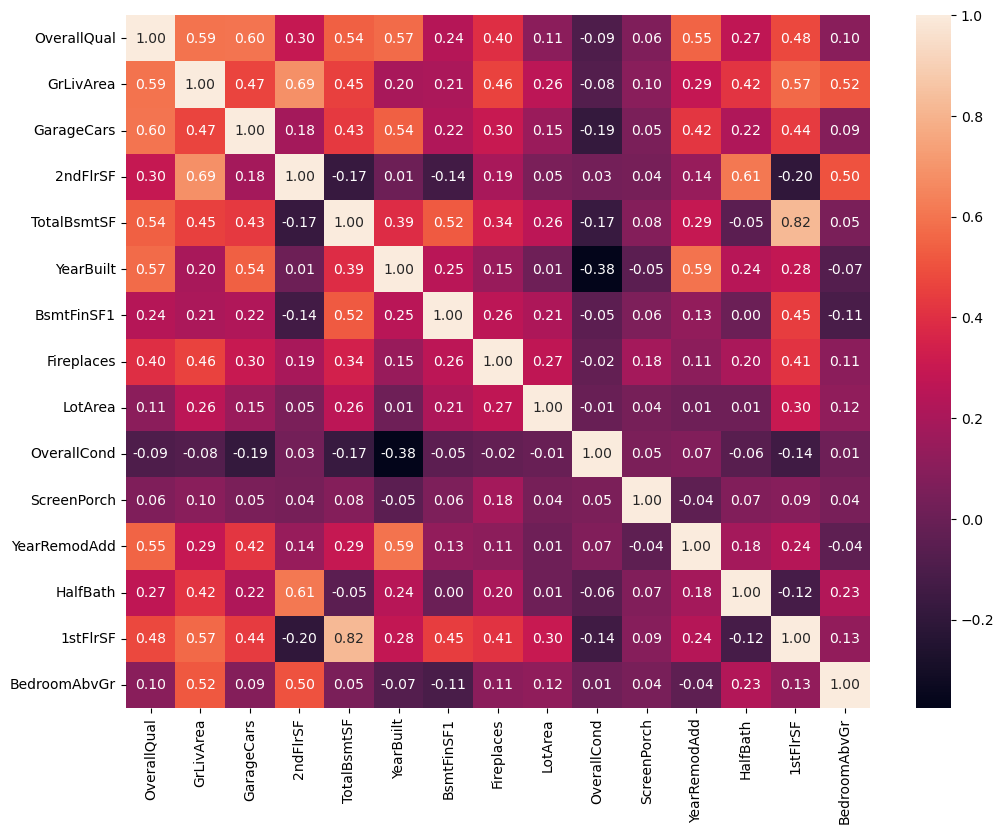

In [12]:
corrmat = train_data[numeric_features].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, annot=True, fmt=".2f")

You can see that some features correlate with each other. For example, 1stFlrSF and TotalBsmtSF have the strongest and the most noticeable correlation, which makes sense. Despite the fact, that both of these features are one of the 'strongest' features, in most cases you will worsen the result if use them together instead of separately. Only the tests with final configurations showed a few improvements in the final score, that's why I use them.

#### Outliers

Now, let's look for outliers in our numeric features.

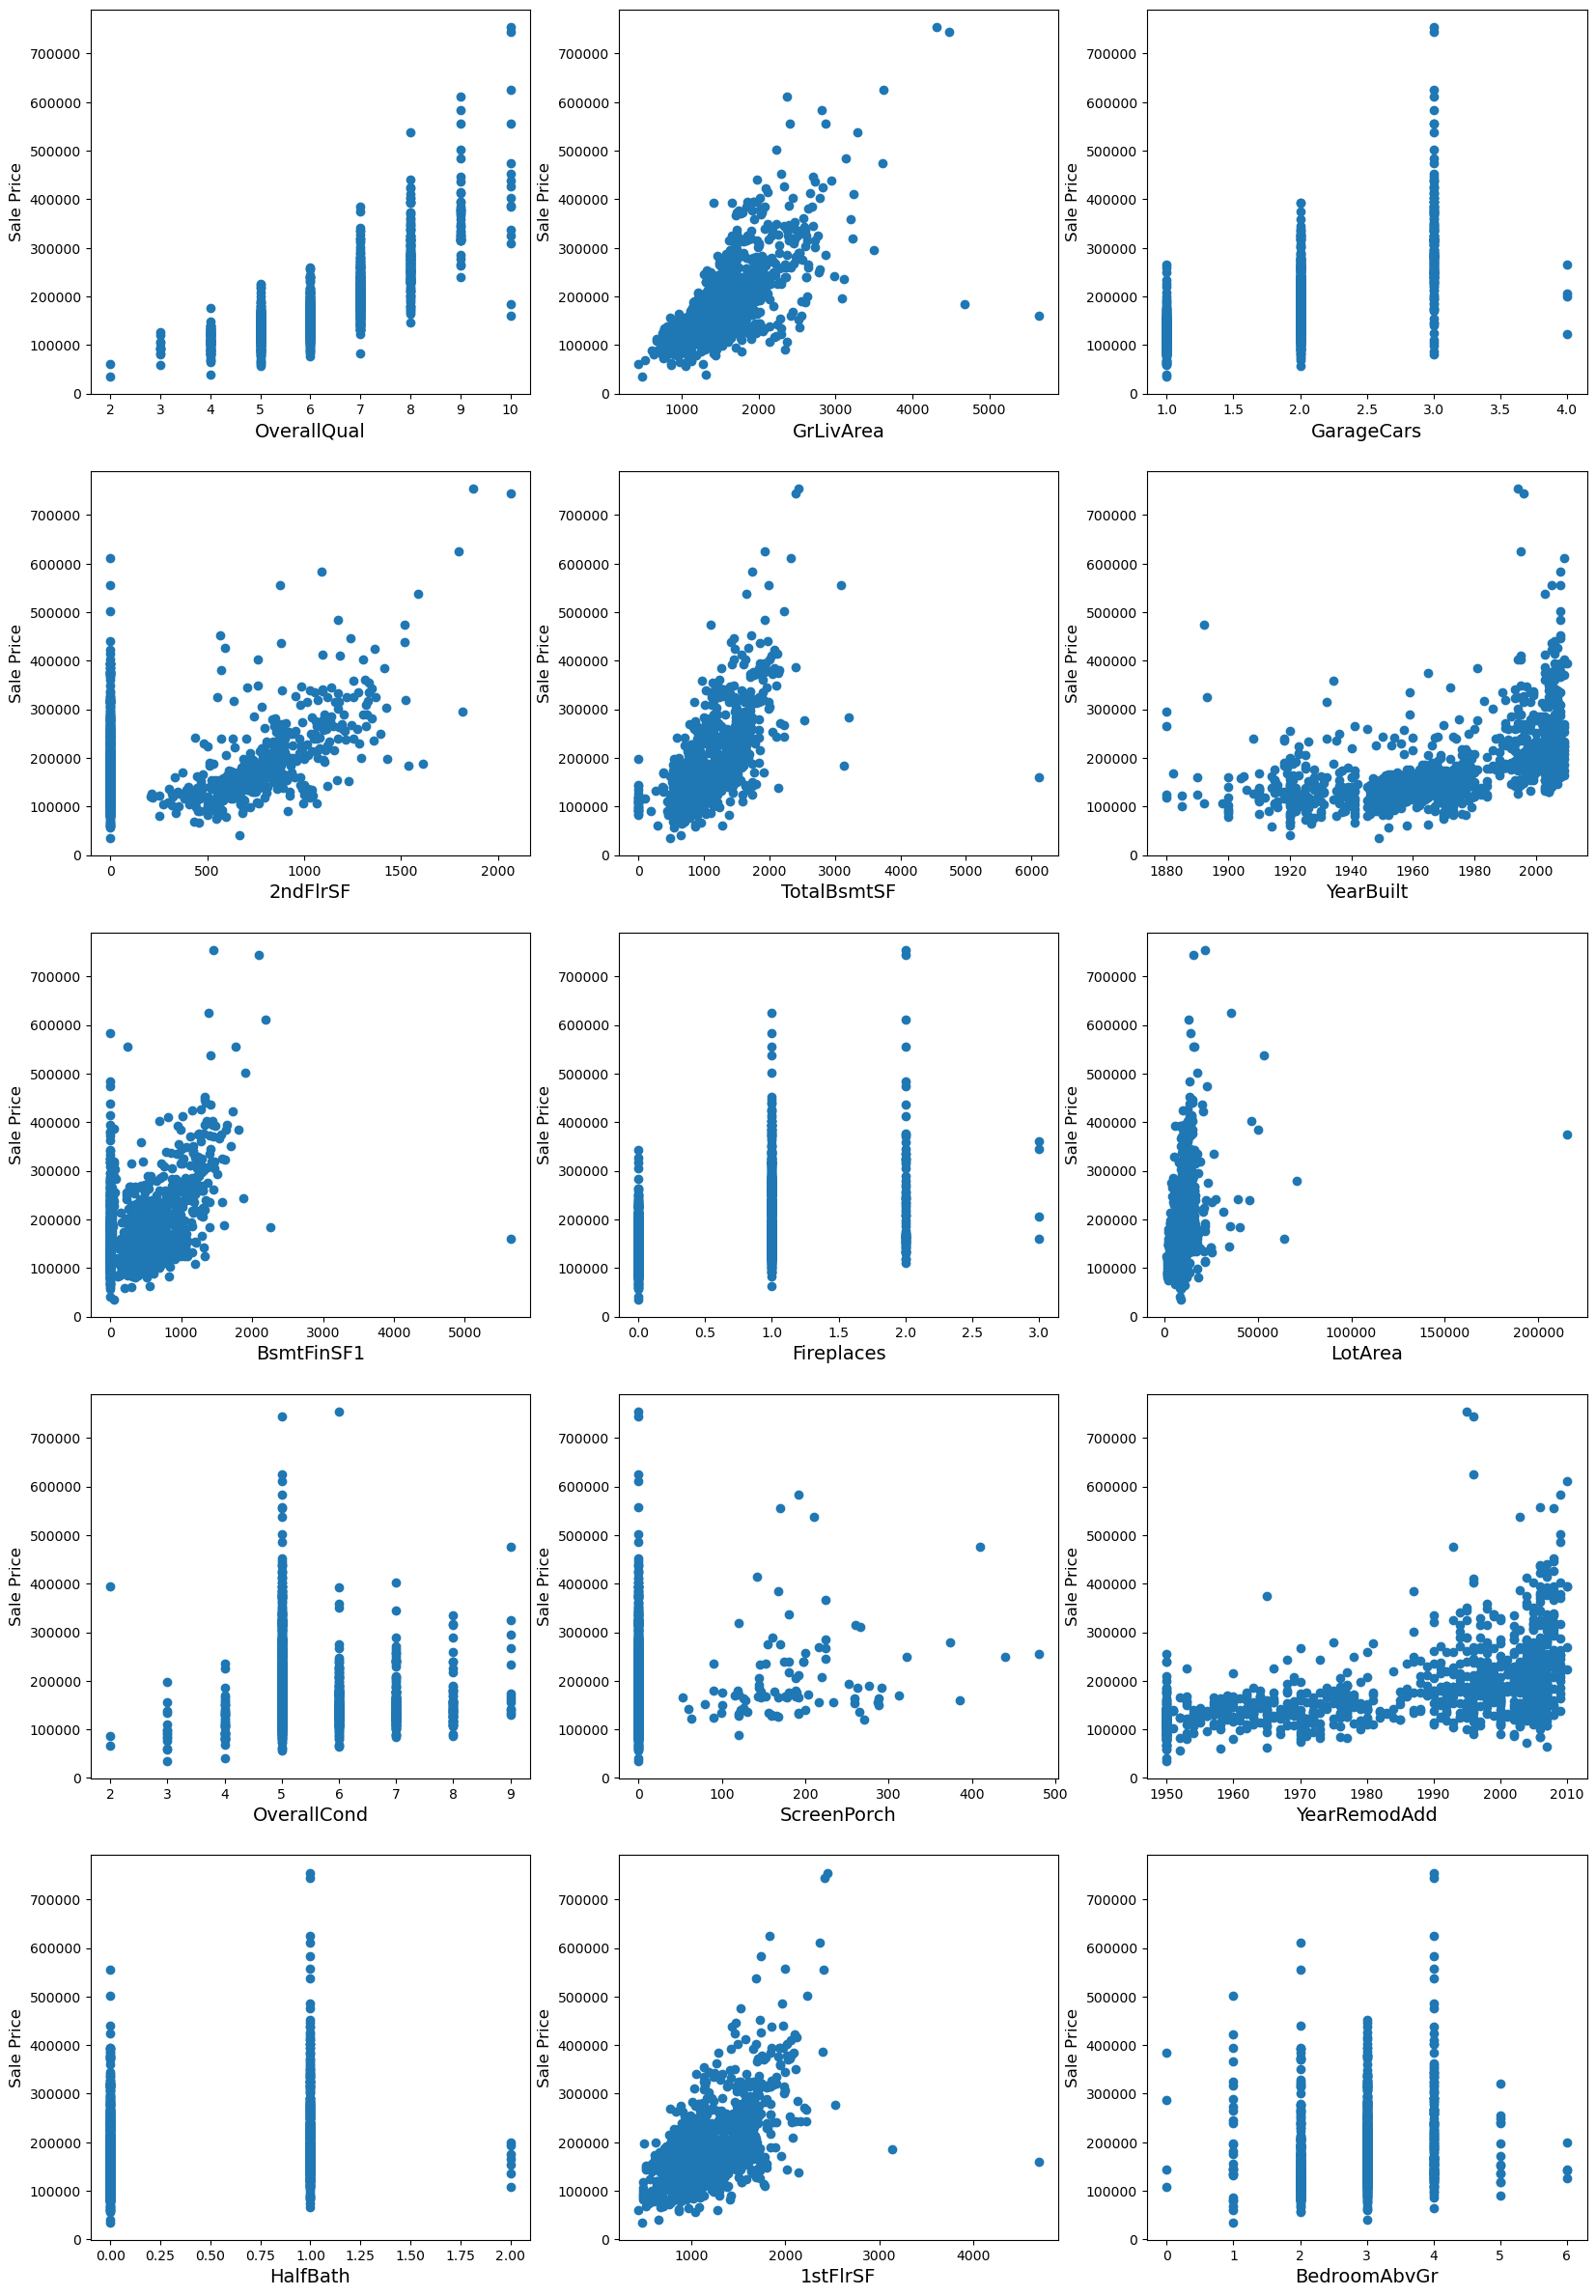

In [13]:
plt.figure(figsize=(20, 30))

for count, value in enumerate(numeric_features):
    plt.subplot(5, 3, count+1)
    plt.scatter(X_num.loc[:, value], pipeline_y.values)
    plt.xlabel(value, fontsize=14)
    plt.ylabel('Sale Price', fontsize=12)
plt.show()

We can clearly see some outliers in GrLivArea, TotalBsmtSF,BsmtFinSF1, LotArea, and 1stFlrSF graphs. To remove them, I create next function.

In [14]:
def remove_outliers(X, y):
    data = pd.concat([X, y], axis=1)
    
    data = data.drop(data['GrLivArea'][data['GrLivArea'] > 4500].index)
    data = data.drop(data['TotalBsmtSF'][data['TotalBsmtSF'] > 2500].index)
    data = data.drop(data['LotArea'][data['LotArea'] > 50000].index)
    data = data.drop(data['BsmtFinSF1'][data['BsmtFinSF1'] > 2500].index)
    data = data.drop(data['1stFlrSF'][data['1stFlrSF'] > 3000].index)
    
    new_y = data.pop('SalePrice')
    new_X = data
    return new_X, new_y

In [15]:
score_data(*remove_outliers(X_num, pipeline_y))

Data score:
Linear regression: 21406.518492434167
Random forest: 17162.80206974104
Gradient boosting: 16415.283416950104


Wow! After removing just a few instances, our score improves noticeably.

### Categorical features

Next, let's see if we have null values in the categorical features of the training dataset.

In [16]:
train_data.select_dtypes(include='O').isnull().sum().sort_values(ascending=False)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
GarageType         81
GarageCond         81
GarageQual         81
GarageFinish       81
BsmtFinType2       38
BsmtExposure       38
BsmtFinType1       37
BsmtQual           37
BsmtCond           37
MasVnrType          8
Electrical          1
Functional          0
KitchenQual         0
CentralAir          0
HeatingQC           0
Heating             0
PavedDrive          0
SaleType            0
MSZoning            0
Street              0
Condition2          0
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
BldgType            0
Foundation          0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
ExterQual           0
ExterCond           0
SaleCondition       0
dtype: int64

And the same thing in the test dataset.

In [17]:
test_data.select_dtypes(include='O').isnull().sum().sort_values(ascending=False)

PoolQC           1456
MiscFeature      1408
Alley            1352
Fence            1169
FireplaceQu       730
GarageCond         78
GarageQual         78
GarageFinish       78
GarageType         76
BsmtCond           45
BsmtQual           44
BsmtExposure       44
BsmtFinType2       42
BsmtFinType1       42
MasVnrType         16
MSZoning            4
Utilities           2
Functional          2
Exterior2nd         1
KitchenQual         1
SaleType            1
Exterior1st         1
LotShape            0
LandContour         0
PavedDrive          0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
Electrical          0
CentralAir          0
HeatingQC           0
Heating             0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Street              0
Foundation          0
ExterCond           0
ExterQual           0
SaleCondition       0
dtype: int64

As we can see, in both datasets PoolQC, MiscFeature, Alley, Fence, and FireplaceQu columns mostly contain null values, so they are bad features, which we will not use.

In [18]:
bad_cat_features = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']

# Remove bad features
other_cat_features = train_data.select_dtypes(include='O').columns.tolist()
for col in bad_cat_features:
    other_cat_features.remove(col)

## Data preprocessing

After data exploration, we need to use collected insights. 

First, we need to get rid of null values. For this purpose, I'll use a simple imputer that changes null on the most frequent value in both datasets.

In [19]:
imputer = SimpleImputer(strategy='most_frequent')
train_data_for_imput = pd.concat([train_data[numeric_features], train_data[other_cat_features]], axis=1)
test_data_for_imput = pd.concat([test_data[numeric_features], test_data[other_cat_features]], axis=1)

imputed_train_data = pd.DataFrame(data=imputer.fit_transform(train_data_for_imput), 
                                  index=train_data.index, 
                                  columns=train_data_for_imput.columns)
imputed_test_data = pd.DataFrame(data=imputer.transform(test_data_for_imput), 
                                 index=test_data.index, 
                                 columns=test_data_for_imput.columns)

Second, use one-hot encoding to transform categorical features into numerical values.

In [20]:
OHE = OneHotEncoder(sparse=False)
train_ohe_df = pd.DataFrame(data=OHE.fit_transform(imputed_train_data[other_cat_features]), 
                            index=imputed_train_data.index)
test_ohe_df = pd.DataFrame(OHE.transform(imputed_test_data[other_cat_features]), 
                           index=imputed_test_data.index)

# In the latest version sklearn raise FutureWarning if columns names aren't strings
train_ohe_df.columns = train_ohe_df.columns.map(str)
test_ohe_df.columns = test_ohe_df.columns.map(str)

Finally, concatenate imputed with the encoded part, and remove outliers using our function.

In [21]:
train_X = pd.concat([imputed_train_data[numeric_features].astype('int32'), train_ohe_df], axis=1)
train_y = train_data['SalePrice']
train_X, train_y = remove_outliers(train_X, train_y)

test_X = pd.concat([imputed_test_data[numeric_features].astype('int32'), test_ohe_df], axis=1)

score_data(train_X, train_y)

Data score:
Linear regression: 16912.488878732904
Random forest: 16165.021180603615
Gradient boosting: 14960.430054963086


Nice, the score greatly improved!

## Model selection and training

As a final model, I decide to use a gradient boosting model, which shows the best result in each scoring. There are a lot of different libraries that provide such models. After a few tests, I choose the CatBoost library. Let's create and train it.

In [22]:
model = CatBoostRegressor(n_estimators=10000, loss_function='RMSE',
                              random_state=0, max_depth=5, 
                              verbose=False, subsample=0.44, random_strength=1.5)
model.fit(train_X, train_y)

## Predicting on test data

And finally, we need to make a prediction using our model and preprocessed train data and then store it as a csv file.

In [23]:
preds_test = model.predict(test_X)
output = pd.DataFrame({'Id': test_X.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)

### Thank you for your attention!

Hope, it was interesting or useful for you. Please, upvote if you like it.